In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import rc
font=rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
from scipy.interpolate import make_interp_spline
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge 
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_squared_error, explained_variance_score
import seaborn as sea
import time
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import regularizers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
import pickle
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import shap
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\10069\.conda\envs\deep\lib\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [6]:
##读取数据集
data_ori1 = pd.read_excel("数据集\\data.xlsx", engine='openpyxl')
data_set1 = data_ori1
info_columns = list(data_set1)
feature_names = list(data_set1)
feature_names.remove('ID')
feature_names.remove('Reactant')
feature_names.remove('Radical')
feature_names.remove('Ea')
flag_name = 'Ea'

##划分训练集和测试集
# rng = np.random.default_rng()
# random_seed = rng.integers(low=0, high=1000)  #随机数种子随机
# print(random_seed)  
random_seed = 411    #随机数种子固定
X_CoRE = data_set1[feature_names]#.to_numpy()
y_CoRE = data_set1[flag_name].values.ravel()
data_train, data_test, y_train_CoRE, y_test_CoRE = train_test_split(
    data_set1, y_CoRE, 
    test_size=0.2, 
    random_state=random_seed
)
X_train_CoRE = data_train[feature_names]
X_test_CoRE = data_test[feature_names]
print(len(X_CoRE), len(y_CoRE), len(X_train_CoRE), len(X_test_CoRE), len(y_train_CoRE), len(y_test_CoRE))
print(np.shape(X_CoRE), np.shape(y_CoRE), np.shape(X_train_CoRE), np.shape(X_test_CoRE), np.shape(y_train_CoRE), np.shape(y_test_CoRE))
# 保存训练集和测试集
data_train.to_excel('./Train.xlsx', index=False)
data_test.to_excel('./Test.xlsx', index=False)

# Z-normalizing the features.
scaler_x = StandardScaler()
scaler_x.fit(X_train_CoRE)
X_train_CoRE_scaled = scaler_x.transform(X_train_CoRE)
X_test_CoRE_scaled = scaler_x.transform(X_test_CoRE)

scaler_y = StandardScaler()
scaler_y.fit(y_train_CoRE.reshape(-1, 1))
y_train_CoRE_scaled = scaler_y.transform(y_train_CoRE.reshape(-1, 1))
y_test_CoRE_scaled = scaler_y.transform(y_test_CoRE.reshape(-1, 1))
print(np.shape(X_train_CoRE_scaled), np.shape(X_test_CoRE_scaled), np.shape(y_train_CoRE_scaled), np.shape(y_test_CoRE_scaled))

X_train_df = pd.DataFrame(X_train_CoRE_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_CoRE_scaled, columns=feature_names)
X_sum_df = pd.concat([X_train_df, X_test_df], axis=0, ignore_index=True)
# X_sum_df ##check the data frame

# XGBoost Hyperopt
# 定义超参数搜索空间

parameter_space_xgb = {
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-1)),
    'n_estimators': hp.quniform('n_estimators', 30, 80, 1),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
    'min_child_weight': hp.quniform('min_child_weight', 2, 5, 1),
    'gamma': hp.uniform('gamma', 0, 0.3),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-3), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-3), np.log(10))
}

# 定义目标函数
def xgb_objective(params):
    # 处理 max_depth 中的 None 值
    params['max_depth'] = int(params['max_depth']) # None if params['max_depth'] == 0 else params['max_depth']
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    # 打印当前参数
    print("Parameters: ", params)
    model = xgb.XGBRegressor(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        gamma=params['gamma'],
        random_state=random_seed
    )

    # 使用交叉验证评估模型性能
    mse_scores = cross_val_score(model, X_train_CoRE_scaled, y_train_CoRE, cv=10, scoring='neg_mean_squared_error')
    mse = -np.mean(mse_scores)  # 转换为正数的 MSE

    # 返回 MSE，Hyperopt 会最小化该目标值
    return {'loss': mse, 'status': STATUS_OK}

# 运行超参数搜索
trials_xgb = Trials()
best_params_xgb = fmin(
    fn=xgb_objective, 
    space=parameter_space_xgb, 
    algo=tpe.suggest,
    max_evals=200, 
    trials=trials_xgb,
    rstate=np.random.default_rng(random_seed)
)
print("Best parameters found: ", best_params_xgb)

# 处理 hp.choice 返回的索引值
best_params_xgb['max_depth'] = int(best_params_xgb['max_depth'])
best_params_xgb['n_estimators'] = int(best_params_xgb['n_estimators'])
best_params_xgb['min_child_weight'] = int(best_params_xgb['min_child_weight'])

# 使用找到的最佳参数训练模型
best_model_xgb = xgb.XGBRegressor(
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    n_estimators=best_params_xgb['n_estimators'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    min_child_weight=best_params_xgb['min_child_weight'],
    gamma=best_params_xgb['gamma'],
    #reg_alpha=best_params_xgb['reg_alpha'],
    reg_lambda=best_params_xgb['reg_lambda'],
    random_state=random_seed
)

best_model_xgb.fit(X_train_CoRE_scaled, y_train_CoRE)

# 保存最优模型
model_xgb = './XGB.pkl'
joblib.dump(best_model_xgb, model_xgb)
print(f"Model saved to {model_xgb}")
# 查看加载模型的参数
#loaded_model = joblib.load(model_xgb)
#print("Loaded model parameters: ", loaded_model.get_params())
# 如果需要加载模型并进行预测
# y_pred = loaded_model.predict(X_test_CoRE_scaled)
# print("Predictions: ", y_pred)


594 594 475 119 475 119
(594, 13) (594,) (475, 13) (119, 13) (475,) (119,)
(475, 13) (119, 13) (475, 1) (119, 1)
Parameters:                                                                                                            
{'colsample_bytree': 0.936702992163174, 'gamma': 0.09509707424893167, 'learning_rate': 0.0005288829871705986, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 76, 'reg_alpha': 0.05388870930475704, 'reg_lambda': 0.03389336161819907, 'subsample': 0.7586649017559662}
Parameters:                                                                                                            
{'colsample_bytree': 0.8019956666112833, 'gamma': 0.28114124660085704, 'learning_rate': 0.08480733774171198, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 78, 'reg_alpha': 2.1648676075726705, 'reg_lambda': 0.23434566551768837, 'subsample': 0.9059350718778179}
Parameters:                                                                                                

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test):    # 模型评价指标的计算
    y_train_pred = model.predict(X_train)    
    y_test_pred = model.predict(X_test)

    return {
        "Dataset": ["Train", "Test"],
        "MSE": [
            mean_squared_error(y_train, y_train_pred), 
            mean_squared_error(y_test, y_test_pred)
        ],
        "RMSE": [
            np.sqrt(mean_squared_error(y_train, y_train_pred)),
            np.sqrt(mean_squared_error(y_test, y_test_pred))
        ],
        "MAE": [
            mean_absolute_error(y_train, y_train_pred),
            mean_absolute_error(y_test, y_test_pred)
        ],
        "R²": [
            r2_score(y_train, y_train_pred),
            r2_score(y_test, y_test_pred)
        ],
        "EV": [
            explained_variance_score(y_train, y_train_pred),
            explained_variance_score(y_test, y_test_pred)
        ]
    }
    
def plot_scatter(y_train, y_train_pred, y_test, y_test_pred, metrics, title, xlabel, ylabel, xticks, yticks, save_path=None): # 绘制散点图
    plt.figure(figsize=(12,12))
    # plt.rcParams.update({'font.size': 24})
    # plt.rcParams['font.weight'] = 'bold'
    # plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.linewidth'] = 3.0

    # 绘制训练集/测试集的散点图
    plt.scatter(y_train, y_train_pred, color='blue', label='Training data')
    plt.scatter(y_test, y_test_pred, color='red', label='Test data')

    # 获取训练集和测试接的性能指标
    train_metrics = {key: metrics[key][0] for key in metrics}
    test_metrics = {key: metrics[key][1] for key in metrics}

    # 在散点图上添加训练集/测试集统计信息
    plt.text(0.02, 0.98, 
             f'Train: R²={train_metrics["R²"]:.3f}, RMSE={train_metrics["RMSE"]:.3f}, MAE={train_metrics["MAE"]:.3f}',
             transform=plt.gca().transAxes,  # 使用axes的坐标系统
             fontsize=28,
             fontproperties=font,
             horizontalalignment='left',
             verticalalignment='top'
    )
    plt.text(0.02, 0.92,
             f'Test: R²={test_metrics["R²"]:.3f}, RMSE={test_metrics["RMSE"]:.3f}, MAE={test_metrics["MAE"]:.3f}',
             transform=plt.gca().transAxes,  # 使用axes的坐标系统
             fontsize=28,
             fontproperties=font,
             horizontalalignment='left',
             verticalalignment='top'
    )
    # 设置图表标题和坐标轴
    plt.title(title, fontproperties=font, fontsize=28)
    plt.xlabel(xlabel, fontproperties=font, fontsize=28)
    plt.ylabel(ylabel, fontproperties=font, fontsize=28)
    plt.xticks(xticks, fontproperties=font, fontsize=28)
    plt.yticks(yticks, fontproperties=font, fontsize=28)
    plt.plot(np.linspace(min(xticks), max(xticks), 100), np.linspace(min(xticks), max(xticks), 100), linestyle='--', color='black', lw=3)
    # plt.legend(prop={'size': 16})
    plt.legend(prop=font,fontsize=28,frameon=False)
    plt.tight_layout()
    if save_path:
        # plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.savefig(save_path, dpi=400 )
    # plt.show()
    
def export_predictions(data_train, data_test, y_train, y_test, y_train_pred, y_test_pred, info_columns, feature_names, output_dir, prefix): # 导出预测结果
    # 确保输出目录存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    train_error = y_train - y_train_pred
    test_error = y_test - y_test_pred

    # 创建训练集的DataFrame
    df_train_info = data_train[info_columns].copy()  # 只保留前6列信息
    df_train_info['Actual'] = y_train
    df_train_info['Predicted'] = y_train_pred
    df_train_info['Error'] = train_error

    # 创建测试集的DataFrame
    df_test_info = data_test[info_columns].copy()  # 只保留前6列信息
    df_test_info['Actual'] = y_test
    df_test_info['Predicted'] = y_test_pred
    df_test_info['Error'] = test_error

    # 导出训练集和测试集到xlsx文件
    train_file_path = os.path.join(output_dir, f"{prefix}_train.xlsx")
    test_file_path = os.path.join(output_dir, f"{prefix}_test.xlsx")
    df_train_info.to_excel(train_file_path, index=False)
    df_test_info.to_excel(test_file_path, index=False)

    print(f"Training set exported to: {train_file_path}")
    print(f"Test set exported to: {test_file_path}")

Training set exported to: ./XGB\XGB_pred_train.xlsx
Test set exported to: ./XGB\XGB_pred_test.xlsx


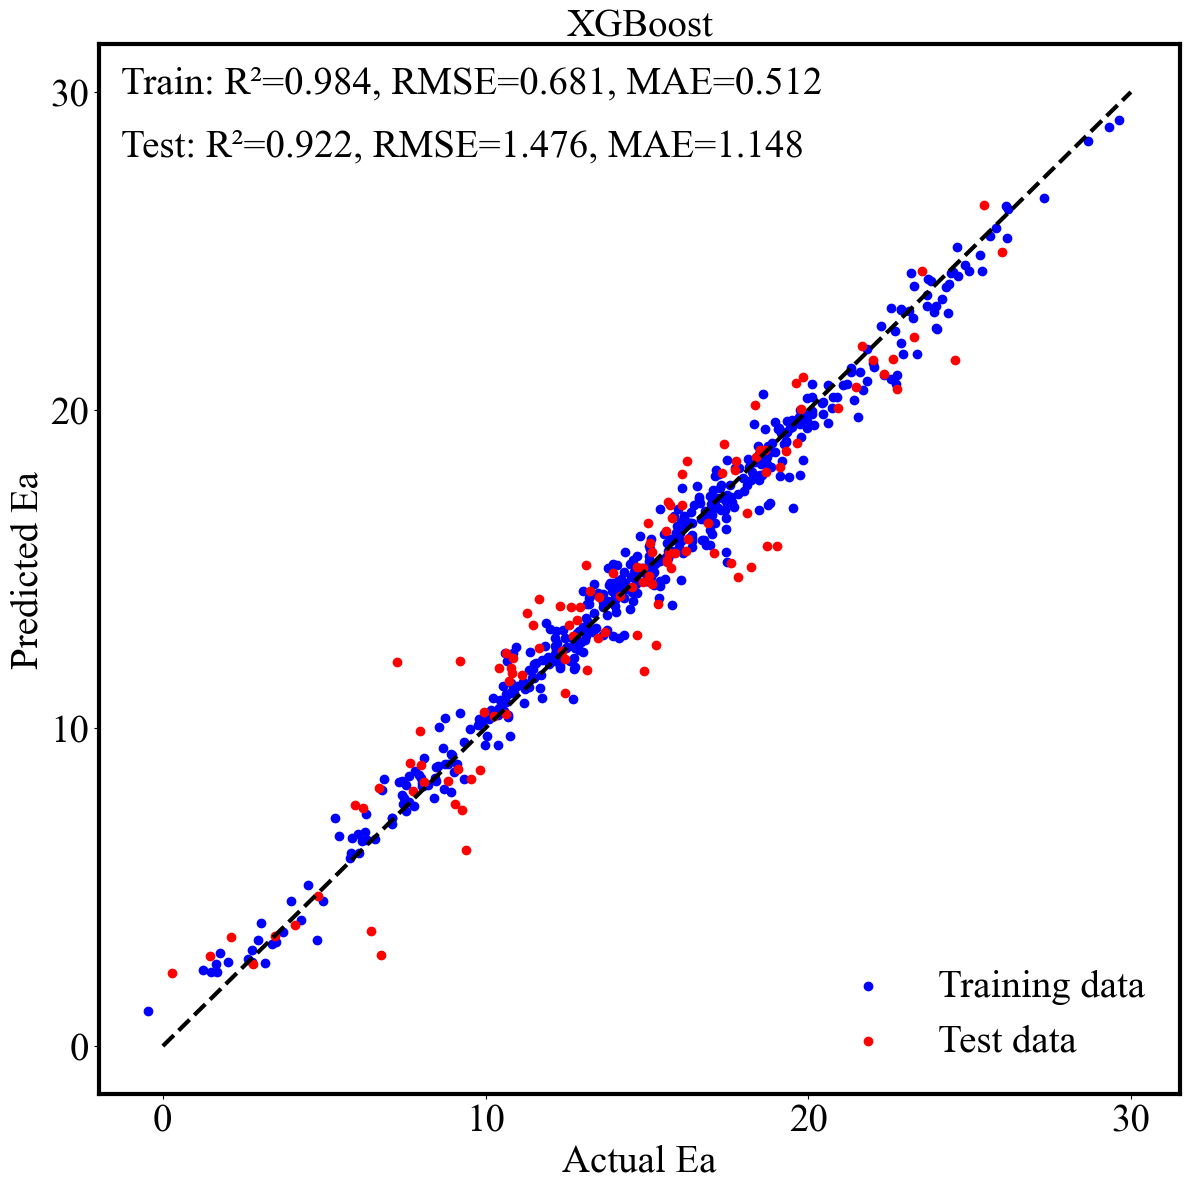

In [14]:
##模型评估
metrics_best_xgb = evaluate_model(best_model_xgb, X_train_CoRE_scaled, y_train_CoRE, X_test_CoRE_scaled, y_test_CoRE)
df_metrics_best_xgb = pd.DataFrame(metrics_best_xgb)
df_metrics_best_xgb["Model"] = "XGB_Bay"
df_metrics_best_xgb.to_excel("./XGB_metrics.xlsx", index=False)
# df_metrics_best_xgb
# 保存

#绘制拟合散点图
y_train_CoRE_pred_xgb = best_model_xgb.predict(X_train_CoRE_scaled)
y_test_CoRE_pred_xgb = best_model_xgb.predict(X_test_CoRE_scaled)
plot_scatter(
    y_train_CoRE, y_train_CoRE_pred_xgb, 
    y_test_CoRE, y_test_CoRE_pred_xgb,
    metrics_best_xgb,
    title='XGBoost',
    xlabel='Actual Ea',
    ylabel='Predicted Ea',
    xticks=[0,10,20,30],
    yticks=[0,10,20,30],
    save_path='./XGB_scatter.png'
)

# 导出预测结果和相关信息
export_predictions(
        data_train, data_test,
        y_train_CoRE, y_test_CoRE,
        y_train_CoRE_pred_xgb, y_test_CoRE_pred_xgb,
        info_columns, feature_names,
        './XGB', 'XGB_pred'
)



# 绘制特征重要性图
explainer_xgb = shap.TreeExplainer(best_model_xgb)
shap_values_xgb = explainer_xgb(X_test_df)

lt.figure(figsize=(12,10))
shap.plots.bar(shap_values_xgb,max_display=30,show=False)
plt.xlabel('mean(|SHAP value|)',fontsize=24,fontproperties=font)
plt.xticks(color='black', fontproperties=font, fontsize=24)
plt.yticks(color='black', fontproperties=font, fontsize=24)
plt.title('SHAP Feature Importance (XGB)', fontproperties=font, fontsize=24)
plt.tight_layout()
plt.savefig('./XGB_SHAP Feature Importance.png',dpi=300,bbox_inches='tight')
plt.close()
# plt.show()
plt.figure(figsize=(12,10))
shap.summary_plot(shap_values_xgb, max_display=50,show=False, color_bar=False)
plt.xlabel('SHAP value (impact on model output)', fontproperties=font, fontsize=24)
plt.xticks(color='black', fontproperties=font, fontsize=24)
plt.yticks(color='black', fontproperties=font, fontsize=24)
plt.title('SHAP Summary Plot (XGB)', fontproperties=font, fontsize=24)
# 获取当前的Axes对象
ax = plt.gca()
# 使用make_axes_locatable创建一个可调整的划分器
divider = make_axes_locatable(ax)
# 在ax右侧添加一个新的Axes用于colorbar，宽度为原Axes宽度的一定比例（例如20%）
# 第二个参数size是指定的宽度比例，第三个参数pad是新Axes与原Axes之间的间距
cax = divider.append_axes("right", size="5%", pad=0.25)
# 现在创建colorbar，并指定刚才创建的cax作为其位置
cbar = plt.colorbar(cax=cax)
#cbar = plt.colorbar()
cbar.set_ticks([]) 
cbar.ax.tick_params(direction='out', length=0, width=0, grid_alpha=0.5)
#cbar.set_label('Feature value', loc='center', size=20, weight='bold')
cbar.ax.text(2.5, 0.99, 'High', transform=cbar.ax.transAxes, ha='center', va='bottom', fontproperties=font, fontsize=24)
cbar.ax.text(2.5, 0.01, 'Low', transform=cbar.ax.transAxes, ha='center', va='top', fontproperties=font, fontsize=24)
cbar.ax.text(3, 0.5, 'Feature value', transform=cbar.ax.transAxes, ha='center', va='center', fontproperties=font, fontsize=24, rotation='vertical')
plt.tight_layout()
plt.savefig('./XGB_SHAP Summary Plot.png',dpi=300,bbox_inches='tight')
plt.close()
# plt.show()